# Two dimensional unequal sampling generalized prolates

This example is not unlike the 2D example of Bronez. We don't have the data, but here goes.

In [1]:
using FFTW, IterTools, Plots, LinearAlgebra, KrylovKit, FINUFFT
using Slepians


""" 

    new_dfn(x, y, bet)

The underlying Kernel function, equation 22-23 in Chave

# Arguments
    - `x::Number` 1-dimensional location
    - `y::Number` 1-dimensional location
    - `bet::Number` 1-dimensional bandwidth

# Outputs
    - Kernel evaluated between the two points x, y
"""
function new_dfn(x, y, bet)
  x == y && return 2*bet
  sin(2 * pi * bet * sqrt(sum(abs2, x - y)))/(pi * sqrt(sum(abs2, (x - y))))
end

function prod_dfn(x, y, bet)
    if typeof(x) <: Number
        return new_dfn(x, y, bet)
    else
        (length(x) != length(y) || length(x) != length(bet)) && error("Lengths of x, y, bet must be the same.")
        return prod(i -> new_dfn(x[i], y[i], bet[i]), 1:length(x))
    end
end

""" 

    efn(x, y, f)

The FT matrix

# Arguments
    - `x::Vector` d-dimensional location
    - `y::Vector` d-dimensional location
    - `f::Vector` d-dimensional frequency

# Outputs
    - Frequency-dependent kernel evaluated between the two points x, y
"""
function efn(x, y, f)
    x == y && return 1.0
    f == 0.0 && return 1.0
    exp(-2.0im * pi * f * sum(x .- y))
end

# Product of efn and dfn
function bfn(x, y, f, bet)
    efn(x, y, f) * prod_dfn(x, y, bet)
end

bfn (generic function with 1 method)

# Warmup: No missing data in 1D

In [2]:
NN = 256
tt = collect(1.0:NN)

fB = 1.0/2 # *ones(d)
fA = 1.0/16 # *ones(d)

f = 0.0

RA = [prod_dfn(xy..., fA) for xy in IterTools.product(tt, tt)]
RB = [bfn(xy..., f, fB) for xy in IterTools.product(tt, tt)]

neig = geneigsolve(x->(RA*x, RB*x), 256, 1, :LM, ishermitian = true, isposdef = true)

v, e = dpss_tapers(NN, 16, 3, :both)


([6.163314097538071e-20 -1.0192217101776395e-18 1.1844123829938749e-17; 6.4791821355045325e-19 -1.0319532754072626e-17 1.153794141417502e-16; … ; 6.479182135504491e-19 1.0319532754072655e-17 1.1537941414175047e-16; 6.163314097538033e-20 1.0192217101776422e-18 1.1844123829938775e-17], [0.9999999999999991, 1.0000000000000002, 1.0000000000000009])

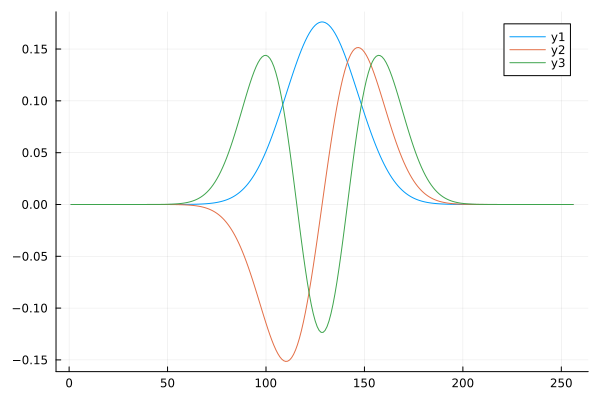

In [3]:
plot(v)

# Warmup: Missing data problem in 1D

In [4]:
NN = 256
tt = (1.0:NN).^(1.05)

fB = 1.0/2 # *ones(d)
fA = 1.0/16 # *ones(d)

f = 0.0

RA = [prod_dfn(xy..., fA) for xy in IterTools.product(tt, tt)]
RB = [bfn(xy..., f, fB) for xy in IterTools.product(tt, tt)]

neig = geneigsolve(x->(RA*x, RB*x), 256, 1, :LM, ishermitian = true, isposdef = true)

([0.9999999999404567], [[-1.9747564349370207e-5, -7.062243074079235e-5, -0.0001838120154493437, -0.00040455292267902983, -0.0007939643828388754, -0.0014330371737333873, -0.002417956239631795, -0.0038585106362406547, -0.005868049851132381, -0.008552992808340947  …  0.0028876959956360797, 0.0017015571015688462, 0.0009122052353929217, 0.00042827169750426217, 0.00016102205513336093, 3.395854672470162e-5, -1.2531779001154194e-5, -1.9905014876188263e-5, -1.3100481545309156e-5, -4.904256261533543e-6]], ConvergenceInfo: no converged values after 100 iterations and 3101 applications of the linear map;
norms of residuals are given by (3.3658663539497264e-9,).
)

In [5]:
lam_orth, u_orth = gpss_orth(fA, 1, tt, 0.0, beta = fB)

lam, u = gpss(fA, 1, tt, 0.0, beta = fB)

([1.0000000000000033], ComplexF64[2.7361118603222084e-8 + 0.0im; 1.5714167057867535e-7 + 0.0im; … ; 5.117253342399669e-9 + 0.0im; 2.769985408295492e-29 + 0.0im;;], Cholesky{ComplexF64, Matrix{ComplexF64}}(ComplexF64[1.0 + 0.0im -0.06534534398152574 - 0.0im … -0.0009102308338316301 - 0.0im 0.0005697795924405583 + 0.0im; -0.06534534398152574 + 0.0im 0.9978627090035663 + 0.0im … 0.000773787309168558 + 0.0im -0.000688105497034729 - 0.0im; … ; -0.0009102308338316301 + 0.0im 0.0008316128474588362 - 0.0im … 0.9710556103148197 + 0.0im -0.2005260071180715 + 0.0im; 0.0005697795924405583 - 0.0im -0.000723867258813002 + 0.0im … -0.2150245944902517 + 0.0im 0.9710520812214698 + 0.0im], 'U', 0))

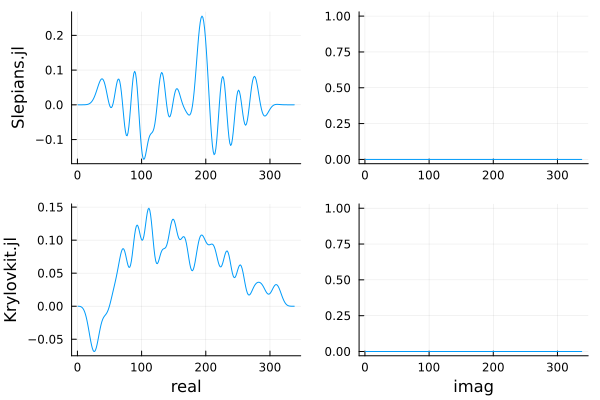

In [6]:
plot(plot(tt, real.(u)), plot(tt, imag.(u)), plot(tt, real.(neig[2][1])), plot(tt, imag.(neig[2][1])),
    layout = (2,2), xlabel = ["" "" "real" "imag"], ylabel = ["Slepians.jl" "" "Krylovkit.jl" ""], 
    legend = false)

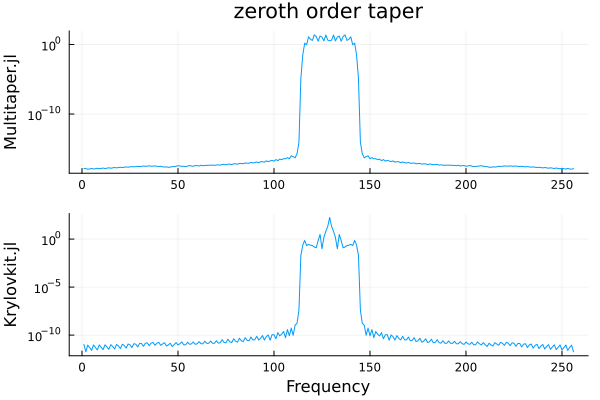

In [7]:
K = 1
w = fA
freqs = LinRange(-0.5, 0.5, NN+1)[1:NN]

ftsleps = mapreduce(k->abs2.(nufft1d3(2*pi*tt, ComplexF64.(u[:,k]), -1, 1e-15, collect(freqs))),hcat, 1:K)

ftsleps2 = abs2.(nufft1d3(2*pi*tt, ComplexF64.(neig[2][1]), -1, 1e-15, collect(freqs)))

plot(plot(ftsleps, yscale = :log10), plot(ftsleps2, yscale = :log10), layout = (2,1), legend = false,
    title = ["zeroth order taper" ""], xlabel = ["" "Frequency"], ylabel = ["Multitaper.jl" "Krylovkit.jl"])

# Warmup: Missing data problem in 2D

This is like the data in the Chave paper, only 2D. Gaps. 

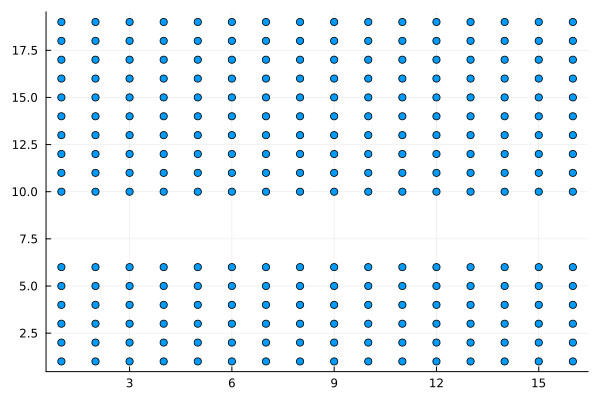

In [8]:
N1 = 16
N2 = 16
t1 = collect(1:N1)
t2 = collect(1:(N2 + 3))[vcat(collect(1:6), collect(10:19))]

mdpts = [(r,t) for r in t1 for t in t2]
mdlocs = [[r,t] for r in t1 for t in t2]

scatter(mdpts, legend = false)

In [9]:
fB = 1.0/2 
fA = 1.0/8 

RA = [dfn(xy..., fA) for xy in IterTools.product(mdlocs, mdlocs)]
RB = [dfn(xy..., fB) for xy in IterTools.product(mdlocs, mdlocs)]

gs = geneigsolve(x->(RA*x, RB*x), 256, 1, :LM, ishermitian = true, isposdef = true) #, howmany = 1, which = :LM, issymmetric = true, T = ComplexF64)

([0.7911124522771529], [[-223.97536984957082, 217.75772659805276, -42.422909203005126, -190.11560178589417, -90.584041363411, 97.67372610405003, -69.81938695545207, -74.42285410513902, -7.344494717374793, 46.46559035061747  …  -68.83675465624528, -76.68822798615089, -7.9067524611241415, 47.471597162483, 14.529431915782274, -95.01832165941931, -152.2293051336246, -26.123470895283155, 182.9024773925888, -215.29816657140302]], ConvergenceInfo: no converged values after 100 iterations and 3101 applications of the linear map;
norms of residuals are given by (3.838646411556076e-5,).
)

In [10]:
gs[2]

1-element Vector{Vector{Float64}}:
 [-223.97536984957082, 217.75772659805276, -42.422909203005126, -190.11560178589417, -90.584041363411, 97.67372610405003, -69.81938695545207, -74.42285410513902, -7.344494717374793, 46.46559035061747  …  -68.83675465624528, -76.68822798615089, -7.9067524611241415, 47.471597162483, 14.529431915782274, -95.01832165941931, -152.2293051336246, -26.123470895283155, 182.9024773925888, -215.29816657140302]

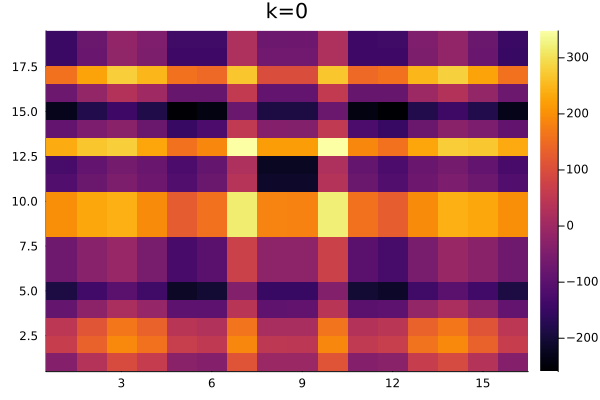

In [11]:
h1 = heatmap(t1, t2, fftshift(reshape(gs[2][1], (16, 16))), title = "k=0")

# General problem: Unequal spacing in array

Here is an array similar to the example in the original Bronez paper. 

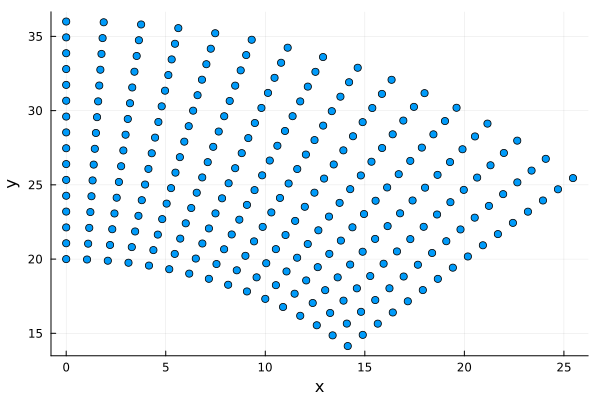

In [12]:
# Set up the array
N1 = 16
N2 = 16

# generate 32 ocncentric circles
rad = collect(LinRange(20,36.0,N1))
thet = collect(LinRange(0.0,45,N2)*pi/180)

pts1 = [(r*sin(t), r*cos(t)) for r in rad for t in thet]

locs1 = [[r*sin(t), r*cos(t)] for r in rad for t in thet]

scatter(pts1, legend = false, xlabel="x", ylabel="y")

In [19]:
# Get the RA and RB matrices, simplifications are provided by Chave, 2020 p 8
d = 2

fB = 1.0/2 # *ones(d)
fA = 1.0/8 # *ones(d)

f = 0.1

RA = [prod_dfn(xy..., [fA, fA]) for xy in IterTools.product(locs1, locs1)]
RB = [bfn(xy..., f, fB) for xy in IterTools.product(locs1, locs1)]

neig = geneigsolve(x->(RA*x, RB*x), 256, 1, :LM, ishermitian = true, isposdef = true) #, howmany = 1, which = :LM, issymmetric = true, T = ComplexF64)

LoadError: Lengths of x, y, bet must be the same.

In [14]:
xx = hcat(locs1...)

2×256 Matrix{Float64}:
  0.0   1.04672   2.09057   3.12869  …  21.1603  22.6555  24.0887  25.4558
 20.0  19.9726   19.8904   19.7538      29.1246  27.9773  26.7532  25.4558

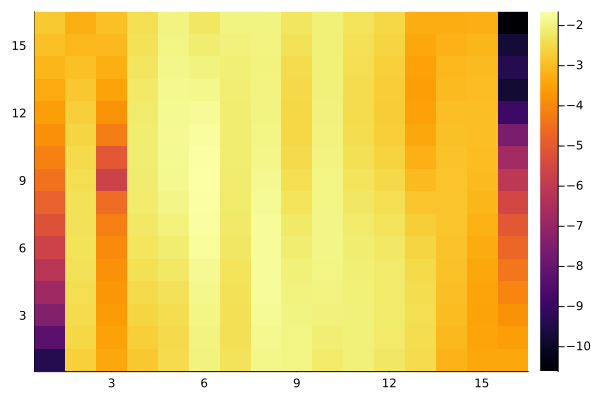

In [15]:
# This is deformed though, so it is hard to visualize with a heatmap
heatmap(log10.(abs2.(reshape(neig[2][1], (16, 16)))))

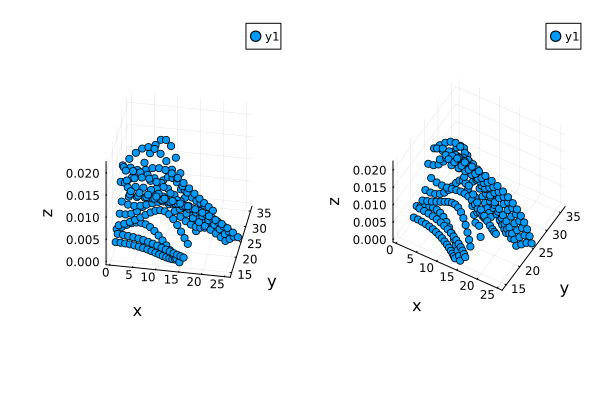

In [16]:
# could do a mesh too
pa = scatter(xx[1,:], xx[2,:], abs2.(neig[2][1]), camera = (10, 35), xlabel = "x", ylabel = "y", zlabel="z")

pb = scatter(xx[1,:], xx[2,:], abs2.(neig[2][1]), camera = (30, 50), xlabel = "x", ylabel = "y", zlabel="z")

plot(pa, pb, layout = (1,2))

In [17]:
freqs1 = LinRange(-1, 1.0, N1)
freqs2 = LinRange(-1, 1.0, N2)

ff = vcat([[xy[1] xy[2]] for xy in IterTools.product(freqs1, freqs2)][:]...)

XX = abs2.(nufft2d1(2*pi*(xx[1,:] .- 12.5)/25., 2*pi*(xx[2,:] .- 12.5)/25., 
        ComplexF64.(neig[2][1]), -1, 1e-15, 2*N1, 2*N2))

32×32×1 Array{Float64, 3}:
[:, :, 1] =
 2.0934       0.909712     0.159164    …  2.15103     0.298809    1.27304
 1.82924      0.259688     0.02919        5.19849     3.57096     0.926389
 0.690165     0.204458     0.157255       3.81962     3.49896     2.93308
 0.560857     0.233452     0.0928361      2.93705     0.86814     0.588999
 0.549815     0.372149     0.0620449      0.560459    0.432227    0.000895315
 0.709554     0.36645      0.00409247  …  0.0766595   0.0477238   0.0655391
 0.869428     0.0899365    0.192543       0.0235251   0.0458219   0.0636844
 0.560397     0.0698971    0.214649       0.0601288   0.0917795   0.0189685
 0.123036     0.164729     0.040126       0.0689508   0.0942306   0.00832487
 0.0871572    0.22857      0.0277952      0.044972    0.0287331   0.0536489
 0.156128     0.0551892    0.0583425   …  0.00599268  0.0157109   0.0354666
 0.211433     0.0406205    0.0991442      0.00360985  0.00681302  0.00516396
 0.0850917    0.0571425    0.178342       0.0054667

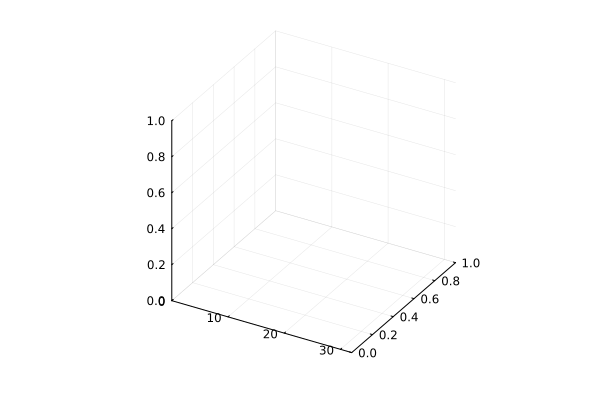

In [18]:
heatmap(log10.(XX))